# Checking microglial marker

## Loading

In [2]:
import scanpy as sc
import pandas as pd
import re
import numpy as np
import anndata as ads

adata = sc.read_h5ad("adata_final_regularized.h5ad")


RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:241; latest registration was registered at /dev/null:241

## Boxplot

In [3]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# 1. Settings
# ------------------------------------------------------------
outdir = "marker_expression_plots"
os.makedirs(outdir, exist_ok=True)

# Define marker genes of interest
markers = ["CX3CR1", "TREM2", "TMEM119", "P2RY12", "CSF1R", "AIF1"]

# Choose grouping variable (e.g. 'dataset', 'AD_status', 'apoe_genotype_std', 'sex')
group_var = "dataset"  # change to 'AD_status' or 'apoe_genotype_std' etc.

# ------------------------------------------------------------
# 2. Normalize + log-transform expression
# ------------------------------------------------------------
# Use a copy to avoid modifying the original integrated object
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

# Extract only genes that exist
genes_found = [g for g in markers if g in adata_norm.var_names]
print(f"✅ Found {len(genes_found)} genes:", genes_found)

# ------------------------------------------------------------
# 3. Convert to DataFrame for plotting
# ------------------------------------------------------------
expr_df = adata_norm[:, genes_found].to_df()
expr_df[group_var] = adata_norm.obs[group_var].values

# Melt to long format
expr_long = expr_df.melt(
    id_vars=group_var,
    var_name="gene",
    value_name="log_expression"
)

# ------------------------------------------------------------
# 4. Plot
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=expr_long[group_var].nunique())

sns.stripplot(
    data=expr_long,
    x="gene", y="log_expression",
    hue=group_var, dodge=True, jitter=0.25, alpha=0.4, size=2, palette=palette
)

sns.boxplot(
    data=expr_long,
    x="gene", y="log_expression",
    hue=group_var, dodge=True, showcaps=True,
    boxprops={"alpha": 0.25},
    whiskerprops={"linewidth": 1.5},
    medianprops={"color": "black", "linewidth": 2},
    palette=palette
)

plt.title(f"Per-cell expression of microglial markers\nGrouped by {group_var}", fontsize=14)
plt.xlabel("Gene")
plt.ylabel("log1p(normalized expression)")

# Fix legend (avoid duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(),
           title=group_var, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
outpath = os.path.join(outdir, f"markers_expression_by_{group_var}.png")
#plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

#print(f"✅ Saved plot to: {outpath}")


RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:241; latest registration was registered at /dev/null:241

🧠 Processing MIT_PFC_Mathys...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


🧠 Processing SEAAD_DLPFC...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


🧠 Processing DEJAEG_Micro...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


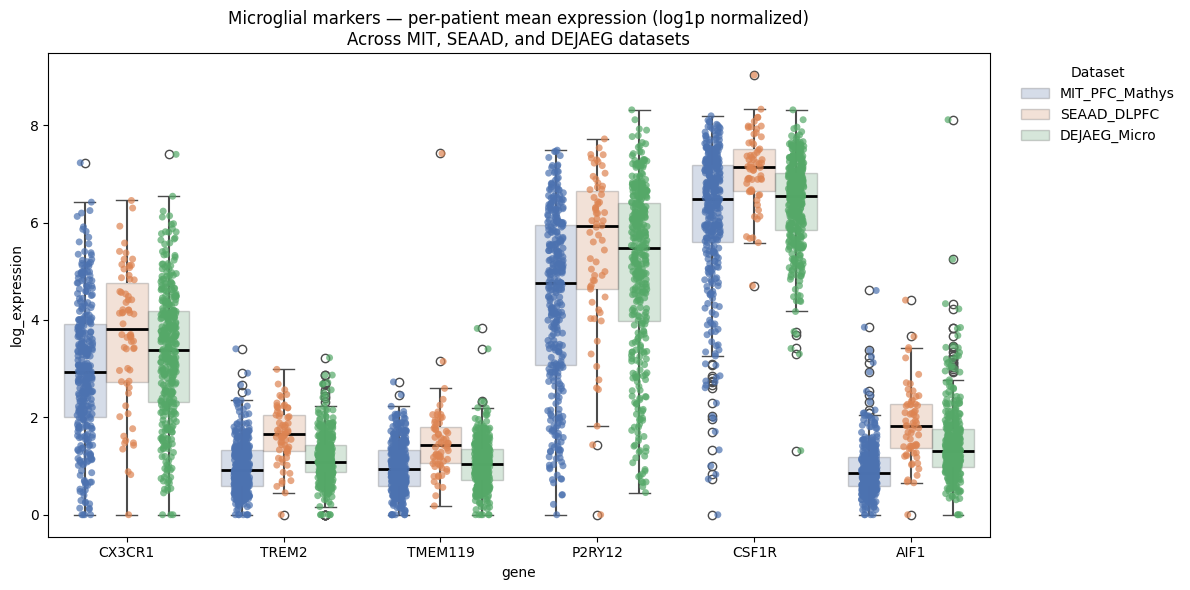

In [7]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Helper: extract per-patient means for a gene list ----
def per_patient_means(adata, markers, dataset_name, groupby, target_sum=1e4):
    genes = [g for g in markers if g in adata.var_names]
    if len(genes) == 0:
        raise ValueError(f"No genes found in {dataset_name}: {markers}")
    
    # Normalize & log transform
    tmp = adata[:, genes].copy()
    sc.pp.normalize_total(tmp, target_sum=target_sum)
    sc.pp.log1p(tmp)
    
    # Create dataframe
    df = tmp.to_df()
    df[groupby] = adata.obs[groupby].astype(str).values
    
    # Per-patient means
    df_means = (
        df.groupby(groupby, as_index=False)[genes]
          .mean()
          .melt(id_vars=[groupby], var_name="gene", value_name="log_expression")
    )
    df_means.rename(columns={groupby: "patient"}, inplace=True)
    df_means["dataset"] = dataset_name
    return df_means


# ---- Define dataset info ----
adata1 = sc.read_h5ad("/mnt/data/mit_pfc_mathysCell2023/PFC_micro.h5ad")
adata2 = sc.read_h5ad("/mnt/data/seaad_dlpfc/seaad_microglia_fixed.h5ad")
adata3 = sc.read_h5ad("/home/ubuntu/human_PFC/dejaeg_preprocessing/microglia_filt.h5ad")

datasets = [
    ("MIT_PFC_Mathys", adata1, "individualID"),
    ("SEAAD_DLPFC", adata2, "Donor ID"),
    ("DEJAEG_Micro", adata3, "individualID")
]

# ---- Define your markers ----
markers = ["CX3CR1", "TREM2", "TMEM119", "P2RY12", "CSF1R", "AIF1"]  # example microglial genes

# ---- Compute per-patient means across all datasets ----
expr_list = []
for name, adata, groupby in datasets:
    print(f"🧠 Processing {name}...")
    df, = (per_patient_means(adata, markers, name, groupby),)
    expr_list.append(df)

expr_all = pd.concat(expr_list, ignore_index=True)

# ---- Plot ----
plt.figure(figsize=(12, 6))
palette = {
    "MIT_PFC_Mathys": "#4C72B0", 
    "SEAAD_DLPFC": "#DD8452", 
    "DEJAEG_Micro": "#55A868"
}

# Dots = patient-level mean expression
sns.stripplot(
    data=expr_all, x="gene", y="log_expression",
    hue="dataset", dodge=True, jitter=0.15, alpha=0.7,
    palette=palette, zorder=2
)

# Boxes = per-patient distribution
sns.boxplot(
    data=expr_all, x="gene", y="log_expression",
    hue="dataset", dodge=True,
    showcaps=True, boxprops={"alpha": 0.25},
    whiskerprops={"linewidth": 1.5},
    medianprops={"color": "black", "linewidth": 2},
    palette=palette, zorder=1
)

plt.title("Microglial markers — per-patient mean expression (log1p normalized)\nAcross MIT, SEAAD, and DEJAEG datasets")

# Clean up legend (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(),
           title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("microglial_markers_expression.png", dpi=300, bbox_inches="tight")
plt.show()


🧠 Processing MIT_PFC_Mathys...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


🧠 Processing SEAAD_DLPFC...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


🧠 Processing DEJAEG_Micro...


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


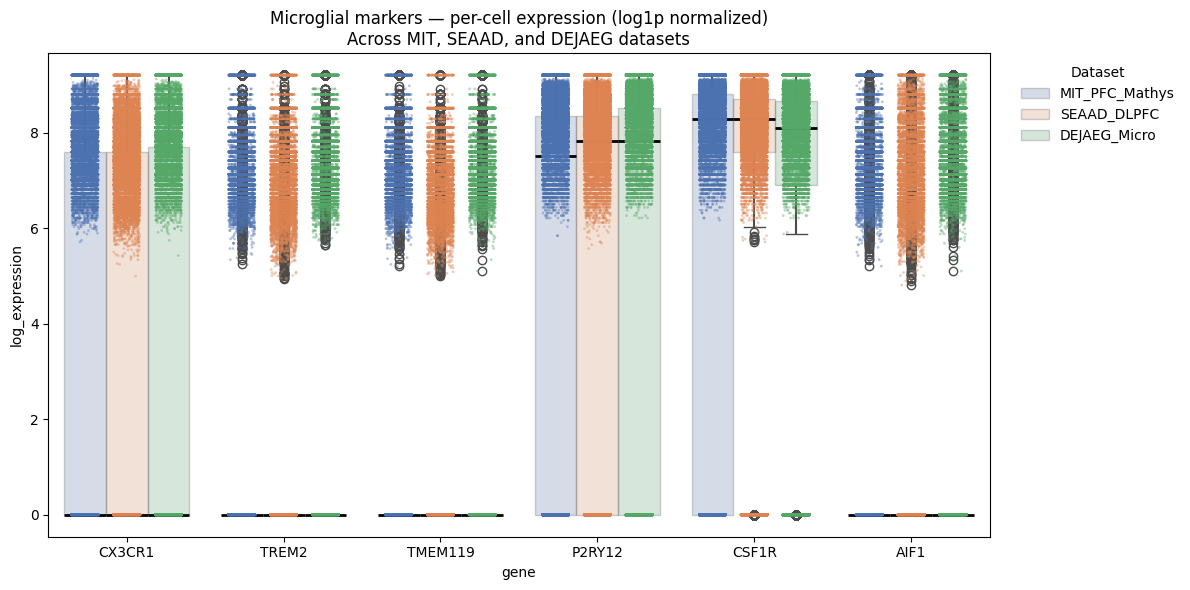

In [9]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Helper: extract per-cell normalized expression for a gene list ----
def per_cell_means(adata, markers, dataset_name, target_sum=1e4):
    genes = [g for g in markers if g in adata.var_names]
    if len(genes) == 0:
        raise ValueError(f"No genes found in {dataset_name}: {markers}")
    
    tmp = adata[:, genes].copy()
    sc.pp.normalize_total(tmp, target_sum=target_sum)
    sc.pp.log1p(tmp)
    
    df = tmp.to_df()
    df["dataset"] = dataset_name
    return df


# ---- Load datasets ----
adata1 = sc.read_h5ad("/mnt/data/mit_pfc_mathysCell2023/PFC_micro.h5ad")
adata2 = sc.read_h5ad("/mnt/data/seaad_dlpfc/seaad_microglia_fixed.h5ad")
adata3 = sc.read_h5ad("/home/ubuntu/human_PFC/dejaeg_preprocessing/microglia_filt.h5ad")

datasets = [
    ("MIT_PFC_Mathys", adata1),
    ("SEAAD_DLPFC", adata2),
    ("DEJAEG_Micro", adata3)
]

# ---- Define your markers ----
markers = ["CX3CR1", "TREM2", "TMEM119", "P2RY12", "CSF1R", "AIF1"] 

# ---- Extract normalized expression per cell ----
expr_list = []
for name, adata in datasets:
    print(f"🧠 Processing {name}...")
    df = per_cell_means(adata, markers, name)
    expr_list.append(df)

expr_all = pd.concat(expr_list, ignore_index=True)

# ---- Melt to long format for plotting ----
expr_long = expr_all.melt(id_vars="dataset", var_name="gene", value_name="log_expression")

# ---- Plot ----
plt.figure(figsize=(12, 6))
palette = {
    "MIT_PFC_Mathys": "#4C72B0", 
    "SEAAD_DLPFC": "#DD8452", 
    "DEJAEG_Micro": "#55A868"
}

# Dots = each cell’s normalized expression
sns.stripplot(
    data=expr_long, x="gene", y="log_expression",
    hue="dataset", dodge=True, jitter=0.25, alpha=0.4,
    size=2, palette=palette
)

# Overlay boxplots for overall distribution
sns.boxplot(
    data=expr_long, x="gene", y="log_expression",
    hue="dataset", dodge=True, showcaps=True,
    boxprops={"alpha": 0.25},
    whiskerprops={"linewidth": 1.5},
    medianprops={"color": "black", "linewidth": 2},
    palette=palette
)

plt.title("Microglial markers — per-cell expression (log1p normalized)\nAcross MIT, SEAAD, and DEJAEG datasets")

# Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(),
           title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("microglial_markers_expression_per_cell.png", dpi=300, bbox_inches="tight")
plt.show()
